In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from common import (
    load_data, plot_data, calculate_error, differenced_data,
    train_test_split, fit_arima_model, forecast_values,
    inverse_differencing, automate_arima, perform_adf_test,preprocess_data
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/pasangchoteensherpa/Downloads/Crypto Time Series Analysis/common.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file_path, index_col=[1], parse_dates=[1],


count     1977.000000
mean     20667.786545
std      16398.604683
min       3188.000000
25%       8019.000000
50%      11777.000000
75%      31027.000000
max      67802.000000
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 1977 entries, 2018-01-01 to 2023-05-31
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1977 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB
None


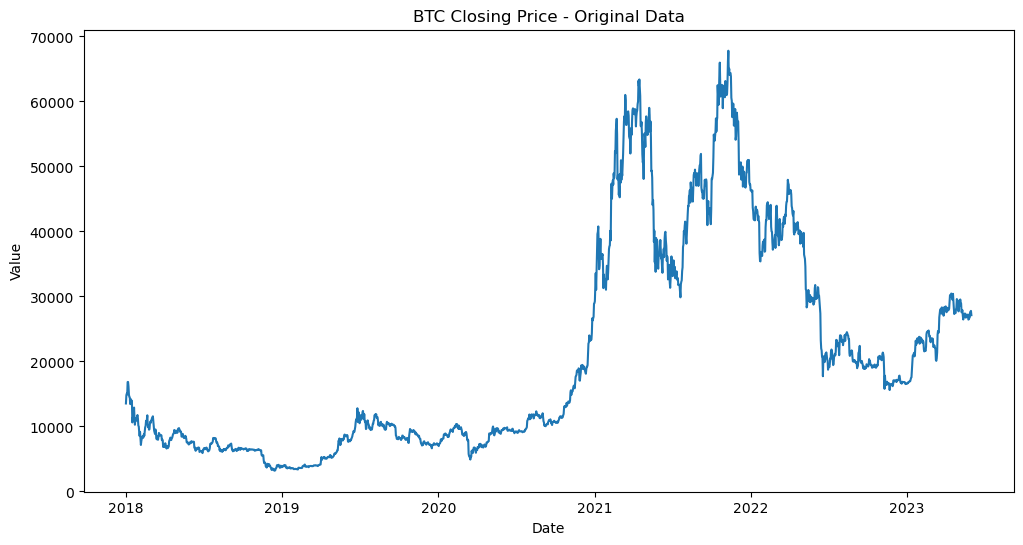

In [2]:
# Load the cryptocurrency data
file_path = 'BTC.csv'  # Change the file path as needed
data = load_data(file_path)['Close']

# Ensure the data is in the correct order and set frequency
data = data.sort_index()  # Sort by index if it's not already sorted
data = data.asfreq('D')  # Set frequency to daily (change if needed)

# Check for and drop duplicate timestamps
data = data[~data.index.duplicated(keep='first')]

data = data.ffill()


# Display data statistics for initial insight
print(data.describe())
print(data.info())

# Visualize original data
plot_data(data, 'BTC Closing Price - Original Data')

In [3]:
# Perform ADF test for stationarity
adf_stat, p_value = perform_adf_test(data)
print('ADF Statistic:', adf_stat)
print('p-value:', p_value)

ADF Statistic: -1.4705702835073042
p-value: 0.5480163380387757


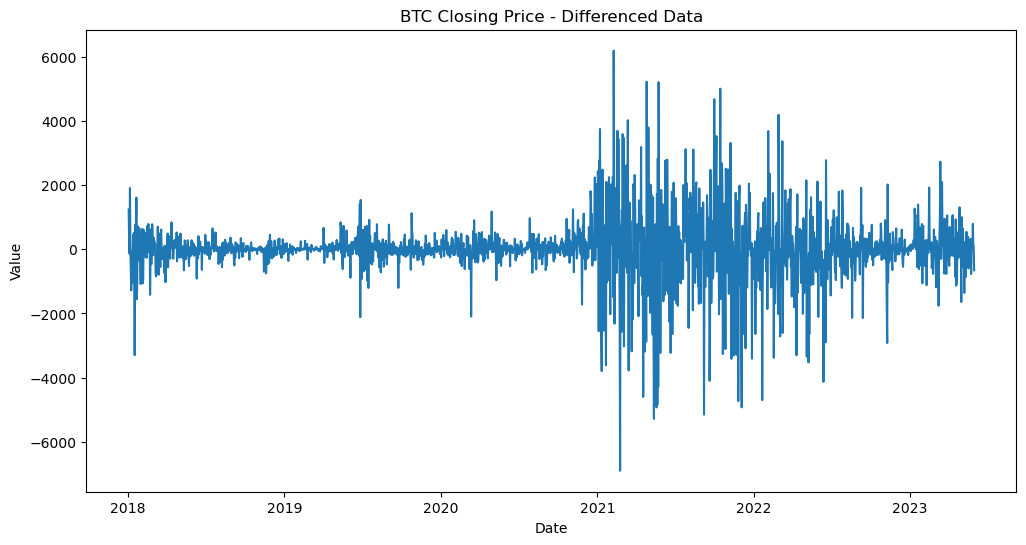

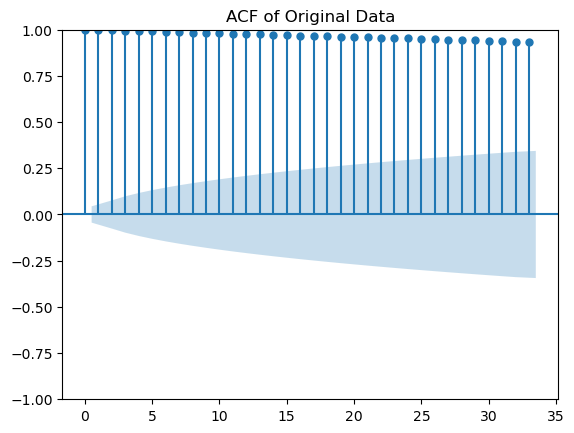

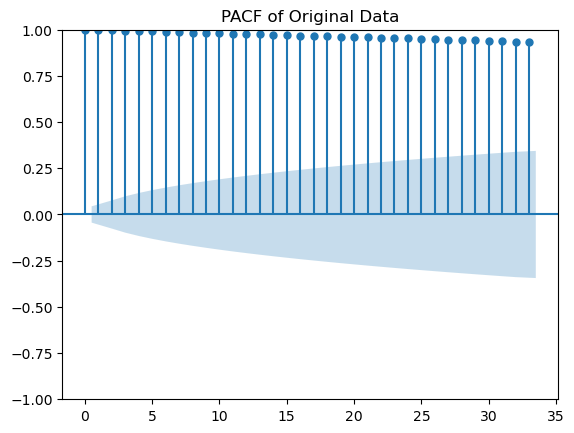

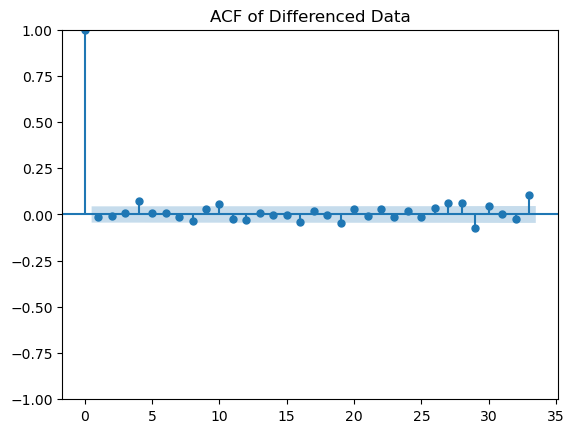

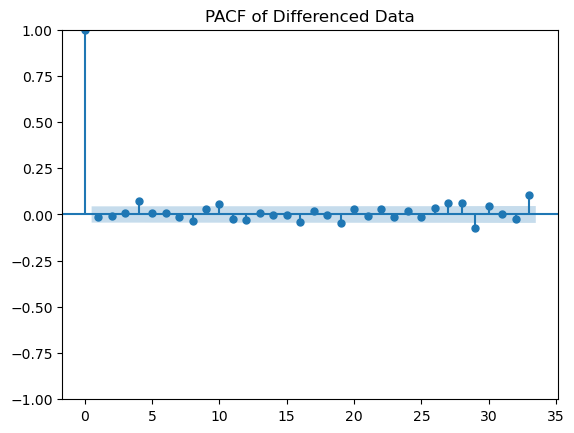

In [4]:
# Differenced Data for Stationarity
diff_data = differenced_data(data)

# Visualize Differenced Data
plot_data(diff_data, 'BTC Closing Price - Differenced Data')

# Plot ACF and PACF for both original and differenced data
for title, series in [('ACF of Original Data', data), ('PACF of Original Data', data),
                      ('ACF of Differenced Data', diff_data), ('PACF of Differenced Data', diff_data)]:
    plot_acf(series)
    plt.title(title)
    plt.show()

In [5]:
import warnings
warnings.filterwarnings("ignore") #ignore warnings

Best ARIMA Order: (2, 0, 2)
Root Mean Squared Error: 18980.425658673696


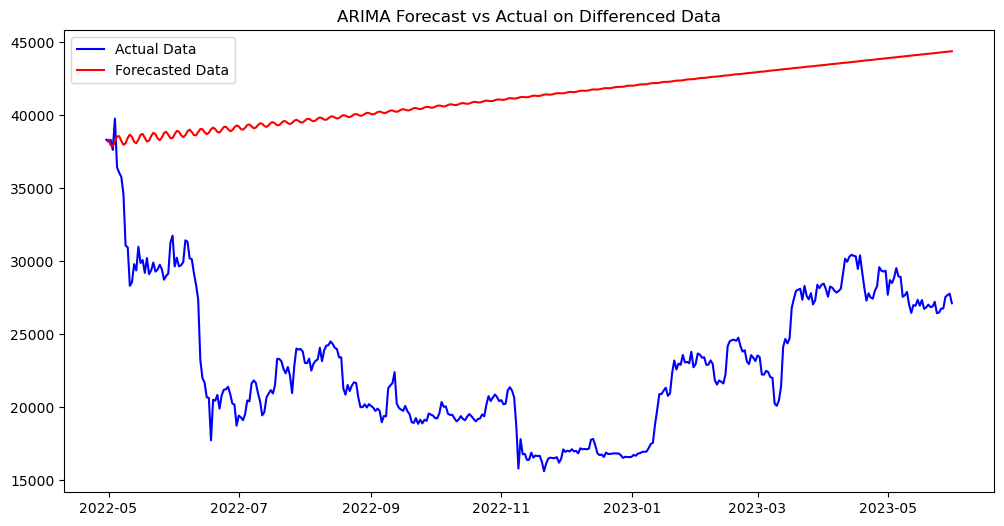

In [6]:
# Automate ARIMA for differenced data
p_values = range(1, 5)
d_values = range(0, 2)
q_values = range(1, 5)

best_order, best_model = automate_arima(data, p_values, d_values, q_values)
print(f'Best ARIMA Order: {best_order}')

# Forecasting using the best model
train_size = int(len(diff_data) * 0.8)
diff_train = diff_data[:train_size]
last_actual_value = data.iloc[train_size - 1]

# Forecasting
diff_forecast = forecast_values(best_model, steps=len(diff_data) - train_size)
forecasted_values = inverse_differencing(last_actual_value, diff_forecast)

# RMSE Calculation
rmse = calculate_error(data.iloc[train_size + 1:], forecasted_values)
print(f'Root Mean Squared Error: {rmse}')

# Visualization of actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], data[train_size:], label='Actual Data', color='blue')
plt.plot(data.index[train_size + 1:], forecasted_values, label='Forecasted Data', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual on Differenced Data')
plt.show()

In [7]:
# Normalization and Standardization

# Normalize and Standardize
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

data_normalized = preprocess_data(data, min_max_scaler)
data_standardized = preprocess_data(data, standard_scaler)

# Split and Automate ARIMA for Normalized Data
train_size = int(len(data_normalized) * 0.8)
data_train_normalized, data_test_normalized = train_test_split(data_normalized)

best_order_normalized, best_model_normalized = automate_arima(data_train_normalized, p_values, d_values, q_values)
print(f'Best ARIMA Order for Normalized Data: {best_order_normalized}')

# Forecasting for Normalized Data
forecast_normalized = best_model_normalized.forecast(steps=len(data_test_normalized))
data_forecast_reshape = forecast_normalized.values.reshape(-1, 1)
data_forecast_reverse = min_max_scaler.inverse_transform(data_forecast_reshape)

data_original_reshape = data_test_normalized.values.reshape(-1, 1)  # Get values and reshape
data_original_reverse = min_max_scaler.inverse_transform(data_original_reshape)


# Calculate RMSE for Normalized Data
rmse_normalized = calculate_error(data_original_reverse, data_forecast_reverse)
print(f'RMSE for Normalized Data: {rmse_normalized}')

Best ARIMA Order for Normalized Data: (3, 0, 4)
RMSE for Normalized Data: 20345.668952790664


In [8]:
# Split and Automate ARIMA for Standardized Data
data_train_standardized, data_test_standardized = train_test_split(data_standardized)

best_order_standardized, best_model_standardized = automate_arima(data_train_standardized, p_values, d_values, q_values)
print(f'Best ARIMA Order for Standardized Data: {best_order_standardized}')

# Forecasting for Standardized Data
forecast_standardized = best_model_standardized.forecast(steps=len(data_test_standardized))
data_forecast_reshape_std = forecast_standardized.values.reshape(-1, 1)
data_forecast_reverse_std = standard_scaler.inverse_transform(data_forecast_reshape_std)

data_original_reshape_std = data_test_standardized.values.reshape(-1, 1)  # Get values and reshape
data_original_reverse_std = standard_scaler.inverse_transform(data_original_reshape_std)


# Calculate RMSE for Standardized Data
rmse_standardized = calculate_error(data_original_reverse_std, data_forecast_reverse_std)
print(f'RMSE for Standardized Data: {rmse_standardized}')

Best ARIMA Order for Standardized Data: (3, 0, 4)
RMSE for Standardized Data: 5281.483552103932


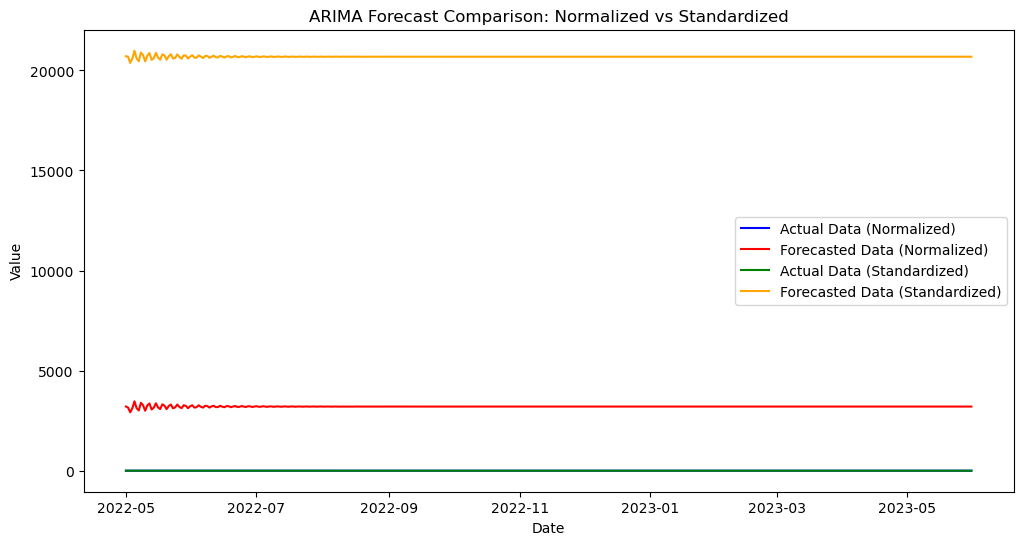

In [9]:
# Visualization of forecasts for both Normalized and Standardized Data
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], data_test_normalized, label='Actual Data (Normalized)', color='blue')
plt.plot(data.index[train_size:], data_forecast_reverse, label='Forecasted Data (Normalized)', color='red')
plt.plot(data.index[train_size:], data_test_standardized, label='Actual Data (Standardized)', color='green')
plt.plot(data.index[train_size:], data_forecast_reverse_std, label='Forecasted Data (Standardized)', color='orange')
plt.legend()
plt.title('ARIMA Forecast Comparison: Normalized vs Standardized')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()